# EfficientGlobalOptimization examples

The EGO algorithm (Jones, 1998) is an adaptative optimization method based on
kriging.

An initial design of experiment is used to build a first metamodel.
At each iteration a new point that maximizes a criterion is chosen as
optimizer candidate.

The criterion uses a tradeoff between the metamodel value and the conditional
variance.

Then the new point is evaluated using the original model and the metamodel is
relearnt on the extended design of experiment.

## Ackley test-case

### Introduction

The Ackley test case is a real function defined in dimension $d$ where $d$ is an integer. 

The Ackley function is defined by the equation:

$$
f(\mathbf{x}) = -a \exp\left(-b\sqrt{\frac{1}{d}\sum_{i=1}^d}x_i^2\right)-\exp\left(\frac{1}{d}\sum_{i=1}^d \cos(c x_i)\right)+a+\exp(1)
$$

for any $\mathbf{x} \in [-15,15]^d$. However, we consider the smaller interval $[-4,4]^d$ in this example, for visual purposes.

We use the dimension $d=2$ with the parameters $a=20$, $b=0.2$, $c=2\pi$. 

The solution is 
$$
\mathbf{x}^\star=(0,0,...,0)
$$

where 

$$
f_{min} = f(\mathbf{x}^\star) = 0.
$$

### Define the problem

In [1]:
import openturns as ot
import math as m

In [2]:
dim = 2

# model
def ackley(X):
    a = 20.0
    b = 0.2
    c = 2.0 * m.pi
    d = len(X)
    sumOfSquared = sum(x**2 for x in X) / d
    sumOfCos = sum(m.cos(c * x) for x in X) / d
    f = - a * m.exp(- b * m.sqrt(sumOfSquared)) \
        - m.exp(sumOfCos) + a + m.exp(1.0)
    return [f]

model = ot.PythonFunction(dim, 1, ackley)

In [3]:
lowerbound = ot.Point([-4.0] * dim)
upperbound = ot.Point([4.0] * dim)

In [4]:
xexact = [0.0] * dim

In [5]:
fexact = model(xexact)
fexact

class=Point name=Unnamed dimension=1 values=[4.44089e-16]

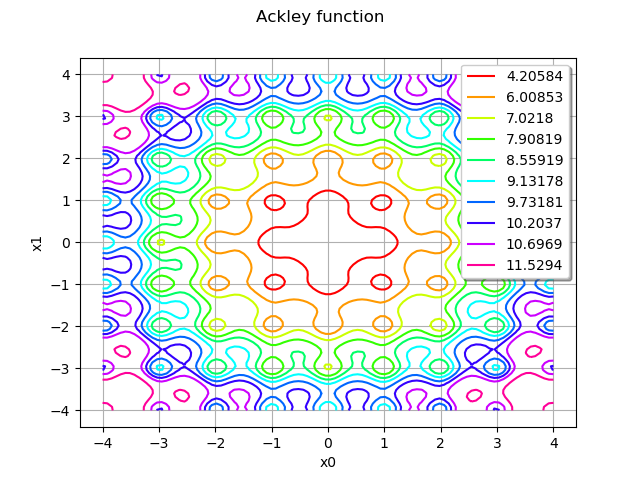

In [6]:
graph = model.draw(lowerbound, upperbound, [100]*dim)
graph.setTitle("Ackley function")
graph

We see that the Ackley function has many local minimas. The global minimum, however, is unique and located at the center of the domain. 

### Create the initial kriging

Before using the EGO algorithm, we must create an initial kriging. In order to do this, we must create a design of experiment which fills the space. In this situation, the `LHSExperiment` is a good place to start (but other design of experiments may allow to better fill the space). We use a uniform distribution in order to create a LHS design with 50 points. 

In [7]:
listUniformDistributions = [ot.Uniform(lowerbound[i], upperbound[i]) for i in range(dim)]
distribution = ot.ComposedDistribution(listUniformDistributions)
sampleSize = 50
experiment = ot.LHSExperiment(distribution, sampleSize)
inputSample = experiment.generate()
outputSample = model(inputSample)

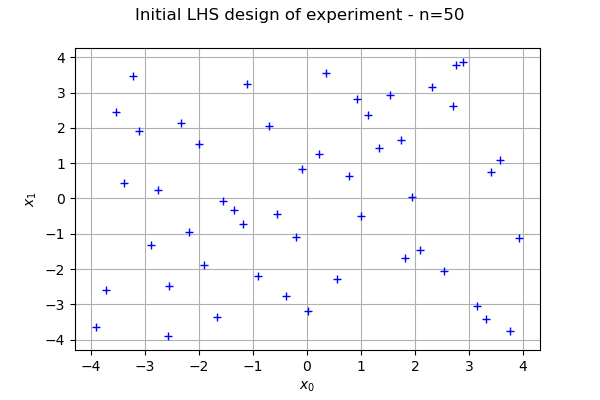

In [8]:
graph = ot.Graph("Initial LHS design of experiment - n=%d" % (sampleSize), "$x_0$", "$x_1$", True)
cloud = ot.Cloud(inputSample)
graph.add(cloud)
graph

We now create the kriging metamodel. We selected the `SquaredExponential` covariance model with a constant basis (the `MaternModel` may perform better in this case). We use default settings (1.0) for the scale parameters of the covariance model, but configure the amplitude to 0.1, which better corresponds to the properties of the Ackley function. 

In [9]:
covarianceModel = ot.SquaredExponential([1.0] * dim, [0.5])
basis = ot.ConstantBasisFactory(dim).build()
kriging = ot.KrigingAlgorithm(inputSample, outputSample, covarianceModel, basis)
kriging.run()

### Create the optimization problem

We finally create the `OptimizationProblem` and solve it with `EfficientGlobalOptimization`. 

In [10]:
problem = ot.OptimizationProblem()
problem.setObjective(model)
bounds = ot.Interval(lowerbound, upperbound)
problem.setBounds(bounds)

In order to show the various options, we configure them all, even if most could be left to default settings in this case. 

The most important method is `setMaximumEvaluationNumber` which limits the number of iterations that the algorithm can perform. In the Ackley example, we choose to perform 10 iterations of the algorithm. 

In [11]:
algo = ot.EfficientGlobalOptimization(problem, kriging.getResult())
algo.setMaximumEvaluationNumber(10)
algo.run()
result = algo.getResult()

In [12]:
result.getIterationNumber()

10

In [13]:
result.getOptimalPoint()

class=Point name=Unnamed dimension=2 values=[0.00823952,-0.0479868]

In [14]:
result.getOptimalValue()

class=Point name=Unnamed dimension=1 values=[0.199646]

In [15]:
fexact

class=Point name=Unnamed dimension=1 values=[4.44089e-16]

Compared to the minimum function value, we see that the EGO algorithm provides solution which is not very accurate. However, the optimal point is in the neighbourhood of the exact solution, and this is quite an impressive success given the limited amount of function evaluations: only 60 evaluations for the initial DOE and 10 iterations of the EGO algorithm, for a total equal to 70 function evaluations. 

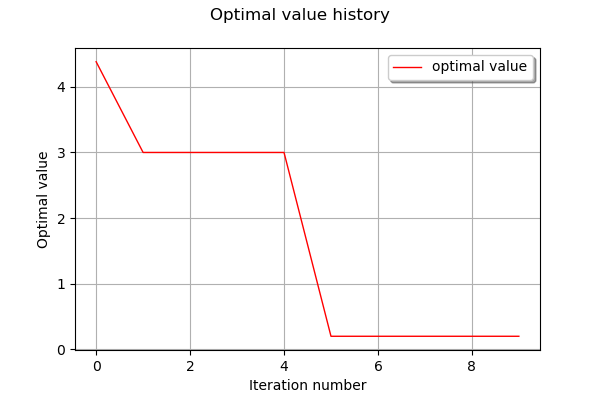

In [16]:
result.drawOptimalValueHistory()

In [17]:
inputHistory = result.getInputSample()

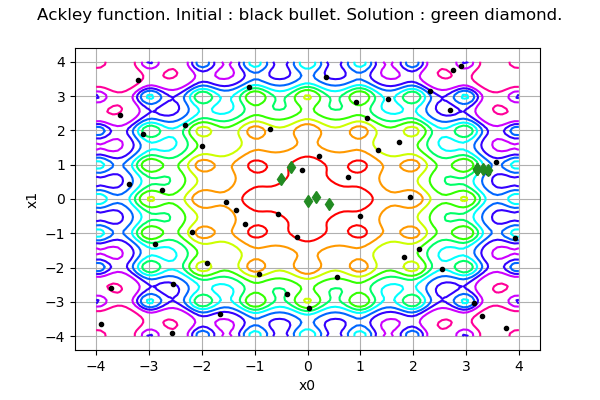

In [18]:
graph = model.draw(lowerbound, upperbound, [100]*dim)
graph.setLegends([""])
graph.setTitle("Ackley function. Initial : black bullet. Solution : green diamond.")
cloud = ot.Cloud(inputSample)
cloud.setPointStyle("bullet")
cloud.setColor("black")
graph.add(cloud)
cloud = ot.Cloud(inputHistory)
cloud.setPointStyle("diamond")
cloud.setColor("forestgreen")
graph.add(cloud)
graph

We see that the initial (black) points are dispersed in the whole domain, while the solution points are much closer to the solution.

However, the final solution produced by the EGO algorithm is not very accurate. This is why we finalize the process by adding a local optimization step. 

In [19]:
algo2 = ot.NLopt(problem, 'LD_LBFGS')
algo2.setStartingPoint(result.getOptimalPoint())
algo2.run()
result = algo2.getResult()

In [20]:
result.getOptimalPoint()

class=Point name=Unnamed dimension=2 values=[-4.20584e-07,1.14354e-06]

The corrected solution is now extremely accurate. 

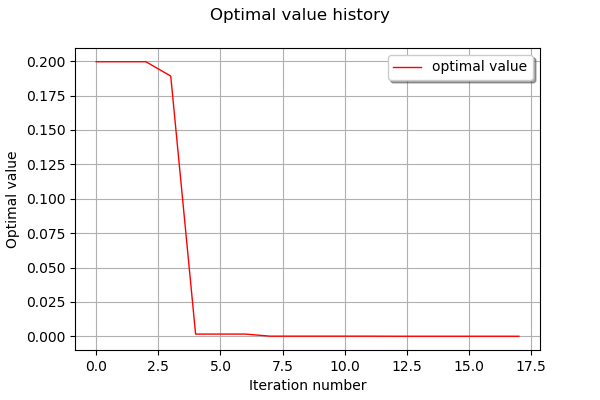

In [21]:
result.drawOptimalValueHistory()

## Branin test-case

### Introduction

The Branin function is defined in 2 dimensions based on the functions $g$:

$$ 
g(u_1, u_2) = \frac{\left(u_2-5.1\frac{u_1^2}{4\pi^2}+5\frac{u_1}{\pi}-6\right)^2+10\left(1-\frac{1}{8 \pi}\right)  \cos(u_1)+10-54.8104}{51.9496}
$$

and $t$:

$$ 
t(x_1, x2) = (15 x_1 - 5, 15 x_2)^T.
$$

Finally, the Branin function is the composition of the two previous functions:

$$
f_{Branin}(x_1, x_2) = g \circ  t(x_1, x_2)
$$

for any $\mathbf{x} \in [0, 1]^2$. 

There are three global minimas:

$$
\mathbf{x}^\star=(0.123895, 0.818329),
$$

$$
\mathbf{x}^\star=(0.542773, 0.151666),
$$

and :

$$
\mathbf{x}^\star=(0.961652, 0.165000)
$$

where the function value is:

$$
f_{min} = f_{Branin}(\mathbf{x}^\star) = -0.97947643837.
$$


We assume that the output of the Branin function is noisy, with a gaussian noise. 
In other words, the objective function is:

$$
f(x_1, x_2) = f_{Branin}(x_1, x_2) + \epsilon
$$

where $\epsilon$ is a random variable with gaussian distribution. 

This time the AEI formulation is used, meaning that the objective has two outputs: the first one is the objective function value and the second one is the noise variance.

Here we assume a constant noise variance: 

$$
\sigma_{\epsilon} = 0.1.
$$

### Define the problem

In [22]:
dim = 2

trueNoiseFunction = 0.1
# model
branin = ot.SymbolicFunction(['x1', 'x2'], 
                             ['((x2-(5.1/(4*pi_^2))*x1^2+5*x1/pi_-6)^2+10*(1-1/8*pi_)*cos(x1)+10-54.8104)/51.9496', 
                              str(trueNoiseFunction)])
transfo = ot.SymbolicFunction(['u1', 'u2'], 
                              ['15*u1-5', '15*u2'])
model = ot.ComposedFunction(branin, transfo)

In [23]:
lowerbound = ot.Point([0.0] * dim)
upperbound = ot.Point([1.0] * dim)

In [24]:
objectiveFunction = model.getMarginal(0)

In [25]:
xexact1 = ot.Point([0.123895,0.818329])
xexact2 = ot.Point([0.542773,0.151666])
xexact3 = ot.Point([0.961652,0.165000])
xexact = ot.Sample([xexact1, xexact2, xexact3])

In [26]:
fexact = objectiveFunction(xexact)
fexact

class=Sample name=Unnamed implementation=class=SampleImplementation name=Unnamed size=3 dimension=1 description=[y0] data=[[-0.979476],[-0.979476],[-0.979476]]

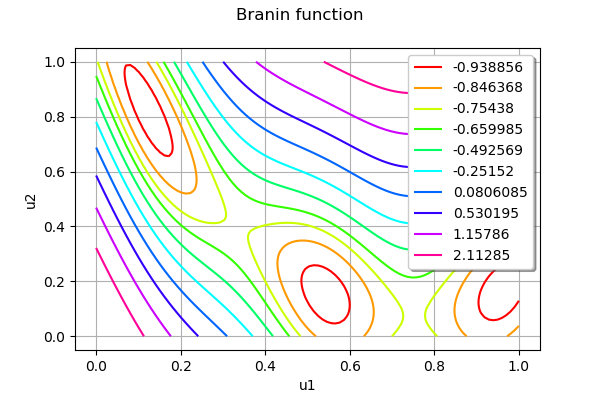

In [27]:
graph = objectiveFunction.draw(lowerbound, upperbound, [100]*dim)
graph.setTitle("Branin function")
graph

The Branin function has three local minimas. 

### Create the initial kriging

In [28]:
distribution = ot.ComposedDistribution([ot.Uniform(0.0, 1.0)] * dim)
sampleSize = 50
experiment = ot.LHSExperiment(distribution, sampleSize)
inputSample = experiment.generate()
modelEval = model(inputSample)
outputSample = modelEval.getMarginal(0)

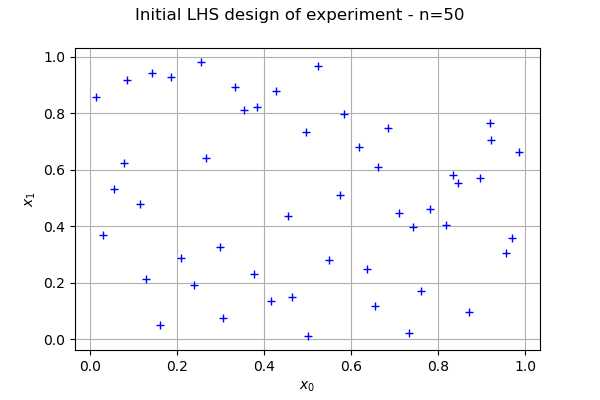

In [29]:
graph = ot.Graph("Initial LHS design of experiment - n=%d" % (sampleSize), "$x_0$", "$x_1$", True)
cloud = ot.Cloud(inputSample)
graph.add(cloud)
graph

In [30]:
covarianceModel = ot.SquaredExponential([1.0] * dim, [1.0])
basis = ot.ConstantBasisFactory(dim).build()
kriging = ot.KrigingAlgorithm(inputSample, outputSample, covarianceModel, basis)

In [31]:
noise = [x[1] for x in modelEval]
kriging.setNoise(noise)
kriging.run()

### Create and solve the problem

In [32]:
# problem
problem = ot.OptimizationProblem()
problem.setObjective(model)
bounds = ot.Interval(lowerbound, upperbound)
problem.setBounds(bounds)

We configure the maximum number of function evaluations to 20. We assume that the function is noisy, with a constant variance. 

In [33]:
# algo
algo = ot.EfficientGlobalOptimization(problem, kriging.getResult())
# assume constant noise var
guessedNoiseFunction = 0.1
noiseModel = ot.SymbolicFunction(['x1', 'x2'], [str(guessedNoiseFunction)])
algo.setNoiseModel(noiseModel) 
algo.setMaximumEvaluationNumber(20)
algo.run()
result = algo.getResult()

In [34]:
result.getIterationNumber()

20

In [35]:
result.getOptimalPoint()

class=Point name=Unnamed dimension=2 values=[0.538732,0.16625]

In [36]:
result.getOptimalValue()

class=Point name=Unnamed dimension=1 values=[-0.978699]

In [37]:
fexact

class=Sample name=Unnamed implementation=class=SampleImplementation name=Unnamed size=3 dimension=1 description=[y0] data=[[-0.979476],[-0.979476],[-0.979476]]

In [38]:
inputHistory = result.getInputSample()

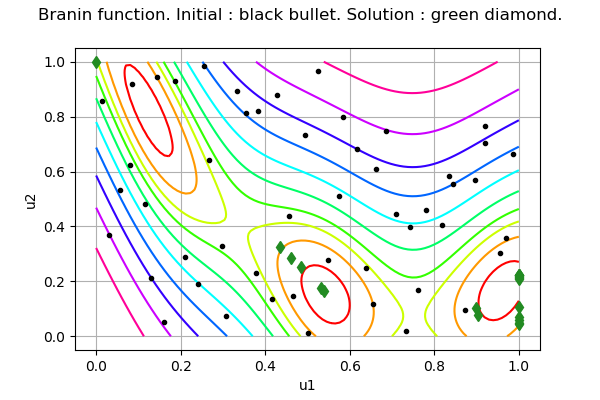

In [39]:
graph = objectiveFunction.draw(lowerbound, upperbound, [100]*dim)
graph.setLegends([""])
graph.setTitle("Branin function. Initial : black bullet. Solution : green diamond.")
cloud = ot.Cloud(inputSample)
cloud.setPointStyle("bullet")
cloud.setColor("black")
graph.add(cloud)
cloud = ot.Cloud(inputHistory)
cloud.setPointStyle("diamond")
cloud.setColor("forestgreen")
graph.add(cloud)
graph

We see that the EGO algorithm found the second local minimum. Given the limited number of function evaluations, the other local minimas have not been explored. 

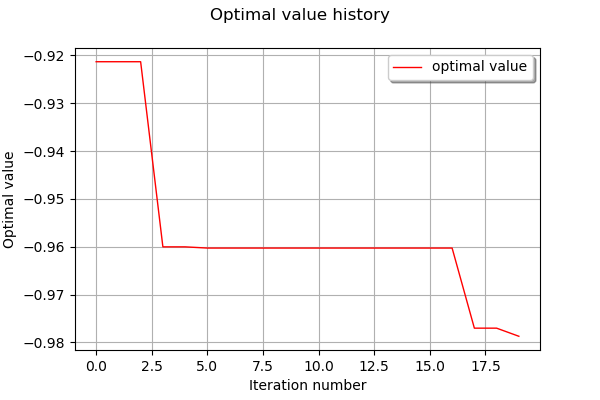

In [40]:
result.drawOptimalValueHistory()